In [118]:
# imports
%pylab inline

from __future__ import division
from time import strftime
from datetime import datetime

import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, scale
from sklearn import svm, linear_model, neighbors, ensemble
from sklearn.grid_search import GridSearchCV

print strftime('%Y-%m-%d %X'), 'clock set'

pd.set_option('max_columns', 50)

Populating the interactive namespace from numpy and matplotlib
2015-05-30 18:28:01 clock set


`%matplotlib` prevents importing * from pylab and numpy


In [46]:
# load CSVs
date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
train = pd.read_csv('../input/train.csv', parse_dates=['Date'], date_parser=date_parser)
test = pd.read_csv('../input/test.csv', parse_dates=['Date'], date_parser=date_parser)

print strftime('%Y-%m-%d %X'), 'clock set'

2015-05-30 17:46:33 clock set


In [194]:
weather = pd.read_csv('../input/weather.csv', na_values='M', parse_dates=['Date'], date_parser=date_parser)[[
        'Station',
        'Date',
        'Tmax',
        'Tmin',
        'Tavg',
        'DewPoint',
        'WetBulb',
        'PrecipTotal'
    ]]
weather['Year'] = [i.year for i in weather['Date']]


In [204]:
weatherDict = {}
for year in set(weather.Year):
    for station in set(weather.Station):
        g = weather[(weather.Year == year) & (weather.Station == station)]
        g['PrecipTotal'] = map(float, g['PrecipTotal'].replace('  T', 0))
        g['3avg'] = pd.rolling_mean(g['Tavg'], 3).replace(NaN, g['Tavg'])
        g['7avg'] = pd.rolling_mean(g['Tavg'], 7).replace(NaN, g['3avg'])
        g['3max'] = pd.rolling_mean(g['Tmax'], 3).replace(NaN, g['Tmax'])
        g['7max'] = pd.rolling_mean(g['Tmax'], 7).replace(NaN, g['3max'])
        g['3dp'] = pd.rolling_mean(g['DewPoint'], 3).replace(NaN, g['DewPoint'])
        g['7dp'] = pd.rolling_mean(g['DewPoint'], 7).replace(NaN, g['3dp'])
        g['3wb'] = pd.rolling_mean(g['WetBulb'], 3).replace(NaN, g['WetBulb'])
        g['7wb'] = pd.rolling_mean(g['WetBulb'], 7).replace(NaN, g['3wb'])
        g['3pt'] = pd.rolling_mean(g['PrecipTotal'], 3).replace(NaN, g['PrecipTotal'])
        g['7pt'] = pd.rolling_mean(g['PrecipTotal'], 7).replace(NaN, g['3pt'])
        weatherDict[str(year) + str(station)] = g
        
weatherAverages = pd.concat(weatherDict.values())

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

In [205]:
weatherDates = weatherAverages.groupby('Date').mean().reset_index()
weatherDates = weatherDates.fillna(0)
weatherDates = weatherDates.drop('Year', 1)

In [219]:
weatherDates['3avg3wb'] = weatherDates['3avg'] * weatherDates['3wb']
weatherDates['TavgWetBulb'] = weatherDates['Tavg'] * weatherDates['WetBulb']

In [220]:
def transformFrame(incomingFrame):
    df = pd.DataFrame.copy(incomingFrame)
    df['Week'] = [i.week for i in df['Date']]
    df['Year'] = [i.year for i in df['Date']]
    df['DayOfYear'] = [i.timetuple().tm_yday for i in df['Date']]
    df['WeekSquared'] = df['Week'] ** 2
    df = pd.concat([df[['Date', 'Year', 'Week', 'WeekSquared']],
                    pd.get_dummies(df['Species']),
                    pd.get_dummies(df['Trap']),
                    ],
                   axis=1)
    return pd.merge(df, weatherDates, how='left', on=['Date'])

In [221]:
trainMini = transformFrame(train)

In [222]:
# # does this matter? not checked yet
for i in trainMini.columns:
    if i not in ('Date', 'Year', 'WnvPresent'):
        trainMini[i] = scale(map(float, trainMini[i]))

In [223]:
def crossValidateUsingYear(trainFrame, year):
    global train
    maskTrain = trainFrame['Year'] != year
    maskValidate = trainFrame['Year'] == year
    
#    clf = linear_model.RidgeCV(alphas=[10]) # try adjusting alpha    
#    clf = ensemble.RandomForestClassifier(n_estimators=150)
    
    param_grid = dict(n_estimators=[100, 250])
    clf = GridSearchCV(ensemble.RandomForestClassifier(), param_grid=param_grid, scoring='roc_auc', n_jobs=1, cv=2, verbose=5)
    
    clf.fit(trainFrame.ix[maskTrain, trainFrame.columns - ['Date', 'Year']], train.ix[maskTrain, 'WnvPresent'])
    
    Z = clf.predict_proba(trainFrame.ix[maskValidate, trainFrame.columns - ['Date', 'Year']])[:, 1]
#    Z = clf.predict(trainFrame.ix[maskValidate, trainFrame.columns - ['Date', 'Year']])
    
    fpr, tpr, thresholds = roc_curve(train.ix[maskValidate, 'WnvPresent'], Z)
    return fpr, tpr

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] n_estimators=100 ................................................
[CV] ....................... n_estimators=100, score=0.286477 -   0.5s
[CV] n_estimators=100 ................................................
[CV] ....................... n_estimators=100, score=0.331010 -   0.5s
[CV] n_estimators=250 ................................................
[CV] ....................... n_estimators=250, score=0.230169 -   1.2s
[CV] n_estimators=250 ................................................
[CV] ....................... n_estimators=250, score=0.327945 -   1.3s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.5s finished



AUC validating with year 2007: 0.602990399431
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] n_estimators=100 ................................................
[CV] ....................... n_estimators=100, score=0.460105 -   0.8s
[CV] n_estimators=100 ................................................
[CV] ....................... n_estimators=100, score=0.570918 -   1.0s
[CV] n_estimators=250 ................................................
[CV] ....................... n_estimators=250, score=0.493332 -   2.0s
[CV] n_estimators=250 ................................................
[CV] ....................... n_estimators=250, score=0.552308 -   2.4s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.3s finished



AUC validating with year 2009: 0.673223979231
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] n_estimators=100 ................................................
[CV] ....................... n_estimators=100, score=0.607616 -   0.8s
[CV] n_estimators=100 ................................................
[CV] ....................... n_estimators=100, score=0.542354 -   0.9s
[CV] n_estimators=250 ................................................
[CV] ....................... n_estimators=250, score=0.639795 -   2.3s
[CV] n_estimators=250 ................................................
[CV] ....................... n_estimators=250, score=0.542026 -   2.6s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.7s finished



AUC validating with year 2011: 0.70921294222
Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] n_estimators=100 ................................................
[CV] ....................... n_estimators=100, score=0.482274 -   0.7s
[CV] n_estimators=100 ................................................
[CV] ....................... n_estimators=100, score=0.421467 -   0.7s
[CV] n_estimators=250 ................................................
[CV] ....................... n_estimators=250, score=0.495919 -   1.7s
[CV] n_estimators=250 ................................................
[CV] ....................... n_estimators=250, score=0.401583 -   2.3s

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.4s finished



AUC validating with year 2013: 0.659639075184
Average: 0.661266599016


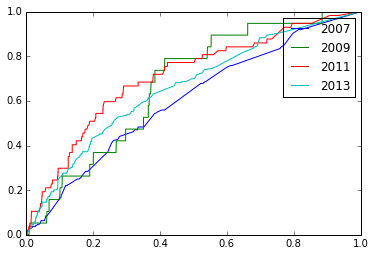

In [224]:
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
sumOfScores = 0
for year in [2007, 2009, 2011, 2013]:
    fpr, tpr = crossValidateUsingYear(trainMini, year)
    plt.plot(fpr, tpr, label=year)
    score = auc(fpr, tpr)
    sumOfScores += score
    print 'AUC validating with year', str(year) + ':', score
print 'Average:', sumOfScores / 4
plt.legend()

0.823679151463


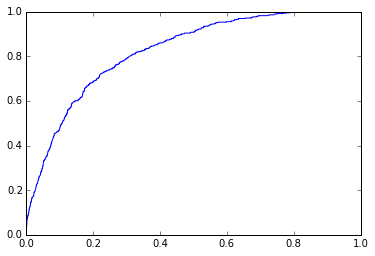

In [225]:
clf = linear_model.RidgeCV(alphas=[0.001, 1, 10]) # try adjusting alpha
clf.fit(trainMini[trainMini.columns - ['Date', 'Year', 'WnvPresent']], train['WnvPresent'])
Z = clf.predict(trainMini[trainMini.columns - ['Date', 'Year', 'WnvPresent']])

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
fpr, tpr, thresholds = roc_curve(train['WnvPresent'], Z)
print auc(fpr, tpr)
plt.plot(fpr, tpr)

In [226]:
x = zip(clf.coef_, trainMini[trainMini.columns - ['Date', 'Year', 'WnvPresent']].columns)
for i in sorted(x, key=lambda i: abs(i[0])):
    print i

(0.0, 'Station')
(2.821161069732625e-05, 'T089')
(-0.00010418497970476892, 'T039')
(-0.00012145648997829994, 'T090')
(-0.00020125554510741495, 'T215')
(0.00020581152466547792, 'T115')
(-0.0002060629085463006, 'T033')
(-0.00020979248438379727, 'T232')
(0.00023926532594487071, 'T226')
(-0.00024654894423292717, 'T054')
(-0.0002734997160587227, 'T135')
(-0.00028016717078571673, 'T103')
(0.000288887114948011, 'T054C')
(-0.00035658759361467673, 'T160')
(-0.00038309806961933646, 'T040')
(0.00040457625618728343, 'T227')
(0.00041276758611275, 'T066')
(0.0004192633514321642, '3max')
(-0.00048086981041706167, 'T128')
(-0.00058523312671354688, 'T151')
(-0.0005865675336735876, 'T147')
(0.00059682284972950583, 'T095')
(-0.00062517755668523023, 'T220')
(0.0006576077352633547, 'T107')
(-0.00067420449886412825, 'CULEX TARSALIS')
(-0.00067590917933557648, 'T237')
(-0.00077997421885811491, 'T158')
(-0.00078907503291247849, 'T012')
(-0.0008255948396254098, 'T156')
(-0.00086693661523895571, 'T159')
(0.0008

##On the test set##

In [227]:
print strftime('%Y-%m-%d %X'), 'clock set'
test = pd.read_csv('../input/test.csv', parse_dates=['Date'], date_parser=date_parser)
testFrame = transformFrame(test)

2015-05-30 19:14:50 clock set


In [228]:
# # does this matter? not checked yet
for i in testFrame.columns:
    if i not in ('Date', 'Year', 'WnvPresent'):
        testFrame[i] = scale(map(float, testFrame[i]))

In [229]:
Z_test = clf.predict(testFrame[testFrame.columns - ['Date', 'Year', 'WnvPresent'] - (testFrame.columns - trainMini.columns )])

In [230]:
print min(Z_test), max(Z_test)
# these values are not all between 0 and 1

-0.172825920916 0.31975870958


In [231]:
Z_test = Z_test + 0.2

In [232]:
print min(Z_test), max(Z_test)
# these values are not all between 0 and 1

0.0271740790844 0.51975870958


In [233]:
with open('ridgecv.csv', 'w') as f:
    f.write('Id,WnvPresent\n')
    for i in xrange(1, 116293 + 1):
        f.write(str(i) + ',' + str(Z_test[i - 1]) + '\n')